In [43]:
import json
import os
import random
import subprocess
import time
from datetime import datetime
from pathlib import Path

import numpy
from IPython.display import clear_output, display
from PIL import Image, ImageDraw
from tqdm import tqdm

In [44]:
def shell(cmd, debug=False, returns_POpen=False, close_fds=False):
    if debug:
        print(cmd)

    if returns_POpen:
        process = subprocess.Popen(cmd, close_fds=close_fds)
        return process

    process = subprocess.run(cmd, stdout=subprocess.PIPE)
    return process.stdout.decode("utf-8").strip().splitlines()

In [45]:
def adb(cmd, debug=False, returns_POpen=False, close_fds=False):
    # This function runs adb commands on your connected device or emulator.
    if type(cmd) == str:
        cmd = cmd.split(" ")
    cmd = ["adb"] + cmd
    return shell(cmd, debug=debug, returns_POpen=returns_POpen, close_fds=close_fds)


adb("wait-for-device")

[]

In [46]:
def pullPhoneScreen(resize_ratio=None, as_numpy=False, print_times=False):
    s = time.time()
    adb("shell screencap -p /sdcard/screen.png")
    adb("pull /sdcard/screen.png ./game.png")
    adb("shell rm /sdcard/screen.png")
    im = Image.open("game.png")
    im = im.convert("RGB")
    if resize_ratio is not None:
        im = im.resize(
            (int(im.width * resize_ratio), int(im.height * resize_ratio)),
            Image.Resampling.LANCZOS,
        )
    if print_times:
        print("pull image took ", time.time() - s)
    if as_numpy:
        return numpy.array(im)
    return im


def yieldPhoneScreen():
    while True:
        yield pullPhoneScreen()

In [47]:
def PillowToCv2(img):
    nimg = np.array(img)
    im = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    return im

In [48]:
import cv2
import numpy as np

In [49]:
class Beholder_Layer:
    def __init__(self, name, data):
        self.name = name
        self.data = data

    def show(self):
        plt.imshow(self.data)

    def chop(self, new_name, x, y, h, w):
        return BeholderLayer(new_name, self.data[y : y + h, x : x + w])

In [50]:
class Beholder_Layer_Chopper:
    def __init__(self, name):
        self.name = name

    def run(self, bh: Beholder):
        pass

In [103]:
class Beholder_Layer_Chopper_Grayscale(Beholder_Layer_Chopper):
    def __init__(self, name, from_layer):
        self.name = name
        self.from_layer = from_layer

    def run(self, bh: Beholder):
        o = {}
        o[self.name] = Beholder_Layer(
            name=self.name,
            data=cv2.cvtColor(bh.layers[self.from_layer].data, cv2.COLOR_BGR2GRAY),
        )
        return o

In [104]:
class Beholder_Layer_Chopper_AtCord(Beholder_Layer_Chopper):
    def __init__(self, name, from_layer, x, y, h, w):
        self.name = name
        self.from_layer = from_layer
        self.x = x
        self.y = y
        self.w = w
        self.h = h

    def run(self, bh: Beholder):
        o = {}
        o[self.name] = bh.layers[self.from_layer].data
        return o

In [105]:
class Beholder_Matcher:
    def __init__(self, label, layer, data):
        self.label = label
        self.layer = layer
        self.data = data

In [106]:
class Beholder:
    def __init__(self, videoFrameGenerator):
        self.generator = videoFrameGenerator()
        self.matchers = []
        self.threshhold = 0.95
        self.layers = {}
        self.layer_modifiers = []

    def addLayerModifer(self, ch: Beholder_Layer_Chopper):
        self.layer_modifiers.append(ch)

    def addDefaultMatcher(self, label, filename, layer="gray"):
        if Path(filename).exists():
            self.matchers.append(
                Beholder_Matcher(label, layer, cv2.imread(filename, 0))
            )
        else:
            print("File is missing")

    def readNextImage(self):
        self.layers["image"] = Beholder_Layer(
            name="image", data=PillowToCv2(next(self.generator))
        )

    def digestImage(self):
        for m in self.layer_modifiers:
            self.layers.update(m.run(self))

    def findMatches(self, matchers=None):
        if matchers is None:
            matchers = self.matchers
        self.readNextImage()
        self.digestImage()
        matches = []
        for m in matchers:
            result = cv2.matchTemplate(self.gray, m.data, method=cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

            if max_val > self.threshhold:
                height, width = template.shape[:2]

                top_left = max_loc
                center = (top_left[0] + width / 2, top_left[1] + height / 2)
                matches.append((name, center))
        return matches

In [107]:
a = Beholder(videoFrameGenerator=yieldPhoneScreen)

In [108]:
a.addLayerModifer(Beholder_Layer_Chopper_Grayscale(name="gray", from_layer="image"))

In [110]:
a.addLayerModifer(
    Beholder_Layer_Chopper_AtCord(
        name="inventory", from_layer="gray", x=800, y=100, w=200, h=350
    )
)

In [111]:
a.addDefaultMatcher(label="Button", layer="gray", filename="./templates/Button.png")
a.addDefaultMatcher(
    label="UnfinishedSmithing",
    layer="inventory",
    filename="./templates/forge_item.png",
)
a.addDefaultMatcher(
    label="FinishedArrow", layer="gray", filename="./templates/FinishedArrow.png"
)

In [112]:
a.readNextImage()

adb: no devices/emulators found
adb: no devices/emulators found


In [73]:
a.digestImage()

AttributeError: 'numpy.ndarray' object has no attribute 'chop'

In [40]:
a.layers.keys()

dict_keys(['image', 'gray', 'random test'])

In [41]:
from matplotlib import pyplot as plt

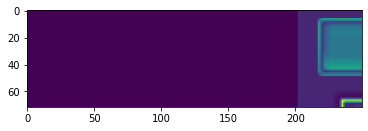

In [46]:
plt.imshow(a.layers["random test"])

In [27]:
while True:
    matches = a.findMatches()
    print(matches)
    if len(matches) > 0:
        adb(f"shell input tap {matches[0][1][0]} {matches[0][1][1]}")
    time.sleep(3.75)

[]
[('Button', (1701.0, 1016.0))]
[('UnfinishedSmithing', (1924.0, 866.0))]
[]
[]
[]
[]
[]
[('FinishedArrow', (1993.0, 891.0))]
[('Button', (1701.0, 1016.0))]
[('UnfinishedSmithing', (1924.0, 866.0))]
[]
[]
[]
[]
[]
[('FinishedArrow', (1993.0, 891.0))]
[]
[('Button', (1701.0, 1016.0))]
[('UnfinishedSmithing', (1924.0, 866.0))]
[]
[]
[]
[]


KeyboardInterrupt: 